### Распределение эмбеддингов текстов. 
Энкодер: all-MiniLM-L6-v2

In [1]:
SEED = 42
ENCODER = "sentence-transformers/all-MiniLM-L6-v2"
MAX_HUMAN_SAMPLES = 10000

MAX_VIS_SAMPLES = 2000

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
from scipy.special import softmax
from random import sample
from scipy.stats import skew, kurtosis
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [3]:
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    
def get_embeddings(tokenizer, model, df, batch_size=16, device=None):
    if device is None:
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    
    model.to(device)
    model.eval()
    all_embeddings = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[i:i + batch_size].tolist()
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

        with torch.no_grad():
            model_output = model(**encoded_input)
            embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

        all_embeddings.append(embeddings.cpu())

        if device.type == "mps":
            torch.mps.empty_cache()

    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings

In [4]:
sns.set(style="whitegrid")

def subsample(X_h, X_ai, max_samples):
    idx_h = list(range(len(X_h)))
    idx_ai = list(range(len(X_ai)))

    if len(idx_h) > max_samples // 2:
        idx_h = sample(idx_h, max_samples // 2)
    if len(idx_ai) > max_samples // 2:
        idx_ai = sample(idx_ai, max_samples // 2)

    X = np.vstack([X_h[idx_h], X_ai[idx_ai]])
    y = np.concatenate([np.zeros(len(idx_h)), np.ones(len(idx_ai))])

    return X, y


def plot_mahalanobis_distributions(scores_human, scores_ai, name):
    plt.figure(figsize=(8, 5))

    all_scores = np.concatenate([scores_human, scores_ai])
    bins = np.histogram_bin_edges(all_scores, bins="auto")

    plt.hist(scores_human, bins=bins, density=True, alpha=0.6, label="Человек")
    plt.hist(scores_ai, bins=bins, density=True, alpha=0.6, label="ИИ")

    plt.title(f"Распределение расстояния Махаланобиса (набор '{name}')")
    plt.xlabel("Квадрат расстояния Махаланобиса")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def plot_roc_curve(y_true, scores, roc_auc, name):
    fpr, tpr, _ = roc_curve(y_true, scores)
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate TPR")
    plt.title(f"ROC-кривая ('{name}')")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def plot_pca_projection(X_human, X_ai, name):
    X, y = subsample(X_human, X_ai, MAX_VIS_SAMPLES)
    X_2d = PCA(n_components=2, random_state=SEED).fit_transform(X)

    plt.figure(figsize=(8, 5))
    scatter = sns.scatterplot(
        x=X_2d[:, 0], y=X_2d[:, 1],
        hue=y, palette={0: "blue", 1: "orange"},
        alpha=0.5, s=35
    )
    plt.title(f"Проекция PCA (набор '{name}')")

    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles=handles, labels=["Человек", "ИИ"])
    plt.tight_layout()
    
    plt.show()


def print_header(title, char="="):
    print(f"\n{char * 100}")
    print(title)
    print(f"{char * 100}")


def print_subheader(title):
    print(f"\n--- {title} ---")


def print_kv(key, value, width=35):
    print(f"{key:<{width}}: {value}")


def covariance_spectrum(cov, top_k=100):
    C = cov.covariance_
    
    eigvals = np.linalg.eigvalsh(C)
    eigvals = eigvals[::-1]
    
    explained = eigvals / eigvals.sum()
    cumulative = np.cumsum(explained)

    fig, ax = plt.subplots(2, 1, figsize=(8, 8))

    ax[0].bar(range(1, top_k + 1), explained[:top_k])
    ax[0].set_title("Объясненная дисперсия (первые компоненты)")
    ax[0].set_xlabel("Номер компоненты")
    ax[0].set_ylabel("Доля объясненной дисперсии")

    ax[1].plot(range(1, top_k + 1), cumulative[:top_k], marker="o")
    ax[1].axhline(0.9, color="r", linestyle="--", label="90%")
    ax[1].axhline(0.95, color="g", linestyle="--", label="95%")
    ax[1].set_title("Накопленная объясненная дисперсия")
    ax[1].set_xlabel("Число компонент")
    ax[1].set_ylabel("Накопленная доля дисперсии")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    

def print_mahalanobis_stats(scores, label, width=50, precision=4):
    stats = {
        "Среднее": scores.mean(),
        "Стд. отклонение": scores.std(),
        "Асимметрия": skew(scores),
        "Эксцесс": kurtosis(scores),
        "95% квантиль": np.quantile(scores, 0.95),
        "99% квантиль": np.quantile(scores, 0.99),
    }
    
    print(f"Статистики расстояния Махаланобиса ({label})")
    print("=" * width)
    for k, v in stats.items():
        print(f"{k:<18s} | {v:>{width-22}.{precision}f}")
    print("=" * width)
    print("")


def print_norm_stats(X, precision=4):
    norms = np.linalg.norm(X, axis=1)
    
    stats = {
        "Среднее значение нормы": norms.mean(),
        "Стандартное отклонение": norms.std(),
    }
        
    print("Статистики норм векторов")
    print("=" * 32)
    for k, v in stats.items():
        print(f"{k:<24s}: {v:.{precision}f}")
    print("=" * 32)
    print("")

In [5]:
human_df = (
    pd.read_csv("../datasets/human_essays.csv", encoding="utf-8")
    .assign(label=0)[["text", "label"]]
    .reset_index(drop=True)
)

if MAX_HUMAN_SAMPLES is not None:
    human_df = human_df[:MAX_HUMAN_SAMPLES]

print(f"Живых текстов: {len(human_df)}")

Живых текстов: 10000


In [6]:
filenames = {
    "Mistral 7B 1": "../datasets/mistral_essays_1.csv",
    "Mistral 7B 2": "../datasets/mistral_essays_2.csv",
    "Mistral 7B 3": "../datasets/mistral_essays_3.csv",
    "Mistral 7B 4": "../datasets/mistral_essays_4.csv",
    "Mistral 7B 5": "../datasets/mistral_essays_5.csv",
    "Llama 3 13B 1": "../datasets/llama_essays_1.csv",
    "Llama 3 13B 2": "../datasets/llama_essays_2.csv",
    "Llama 3 13B 3": "../datasets/llama_essays_3.csv",
    "Llama 3 13B 4": "../datasets/llama_essays_4.csv",
    "Llama 3 13B 5": "../datasets/llama_essays_5.csv",
    "DeepSeek V3.2 1": "../datasets/deepseek_essays_1.csv",
    "DeepSeek V3.2 2": "../datasets/deepseek_essays_2.csv",
    "DeepSeek V3.2 3": "../datasets/deepseek_essays_3.csv",
    "DeepSeek V3.2 4": "../datasets/deepseek_essays_4.csv",
    "DeepSeek V3.2 5": "../datasets/deepseek_essays_5.csv",
    "ChatGPT 1": "../datasets/chatgpt_essays_1.csv",
    "ChatGPT 2": "../datasets/chatgpt_essays_2.csv",
    "ChatGPT 3": "../datasets/chatgpt_essays_3.csv",
    "ChatGPT 4": "../datasets/chatgpt_essays_4.csv",
    "ChatGPT 5": "../datasets/chatgpt_essays_5.csv",
}

ai_datasets = {}
for name, fn in filenames.items():
    df = pd.read_csv(fn, encoding="utf-8").assign(label=1)[["text", "label"]].reset_index(drop=True)
    ai_datasets[name] = df
    print(f"Загружен датасет '{name}'. {len(df)} записей")

Загружен датасет 'Mistral 7B 1'. 1500 записей
Загружен датасет 'Mistral 7B 2'. 1500 записей
Загружен датасет 'Mistral 7B 3'. 1500 записей
Загружен датасет 'Mistral 7B 4'. 1500 записей
Загружен датасет 'Mistral 7B 5'. 1500 записей
Загружен датасет 'Llama 3 13B 1'. 999 записей
Загружен датасет 'Llama 3 13B 2'. 1000 записей
Загружен датасет 'Llama 3 13B 3'. 994 записей
Загружен датасет 'Llama 3 13B 4'. 997 записей
Загружен датасет 'Llama 3 13B 5'. 999 записей
Загружен датасет 'DeepSeek V3.2 1'. 3000 записей
Загружен датасет 'DeepSeek V3.2 2'. 3000 записей
Загружен датасет 'DeepSeek V3.2 3'. 2999 записей
Загружен датасет 'DeepSeek V3.2 4'. 3000 записей
Загружен датасет 'DeepSeek V3.2 5'. 2500 записей
Загружен датасет 'ChatGPT 1'. 2000 записей
Загружен датасет 'ChatGPT 2'. 2000 записей
Загружен датасет 'ChatGPT 3'. 2000 записей
Загружен датасет 'ChatGPT 4'. 2000 записей
Загружен датасет 'ChatGPT 5'. 2000 записей



ENCODER: sentence-transformers/all-MiniLM-L6-v2


100%|█████████████████████████████████████████| 625/625 [01:26<00:00,  7.19it/s]


Статистики норм векторов
Среднее значение нормы  : 1.7149
Стандартное отклонение  : 0.1716

Эмбеддинги живых текстов (train)   : 7000
Эмбеддинги живых текстов (test)    : 3000


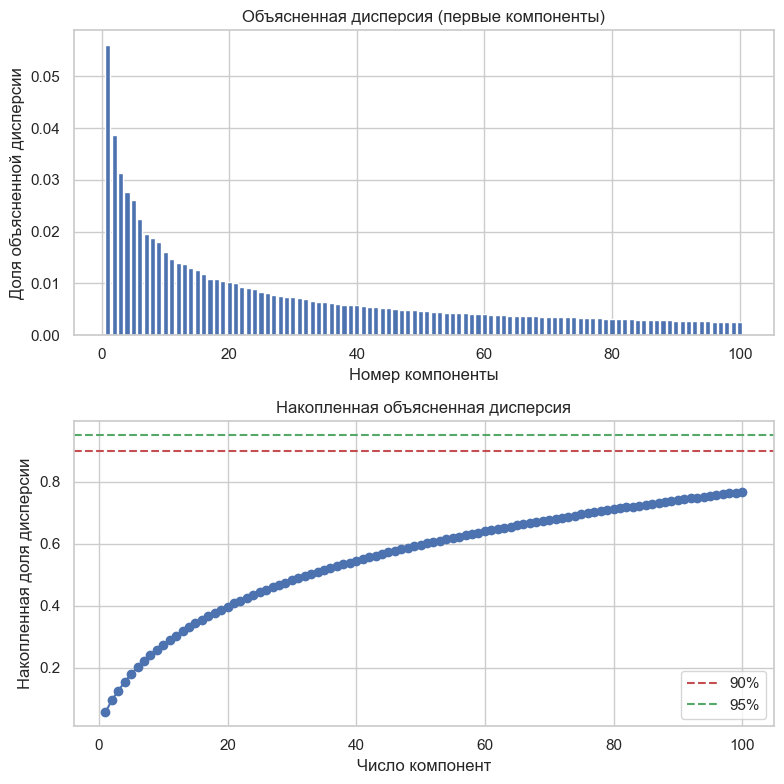


Набор: Mistral 7B 1
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:29<00:00,  3.18it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     376.9366
Стд. отклонение    |                     136.8435
Асимметрия         |                       1.3598
Эксцесс            |                       2.9066
95% квантиль       |                     636.2816
99% квантиль       |                     834.8332

Статистики расстояния Махаланобиса (ии)
Среднее            |                     444.1864
Стд. отклонение    |                     159.6413
Асимметрия         |                       1.4649
Эксцесс            |                       3.4806
95% квантиль       |                     758.0445
99% квантиль       |                     957.6916

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6369


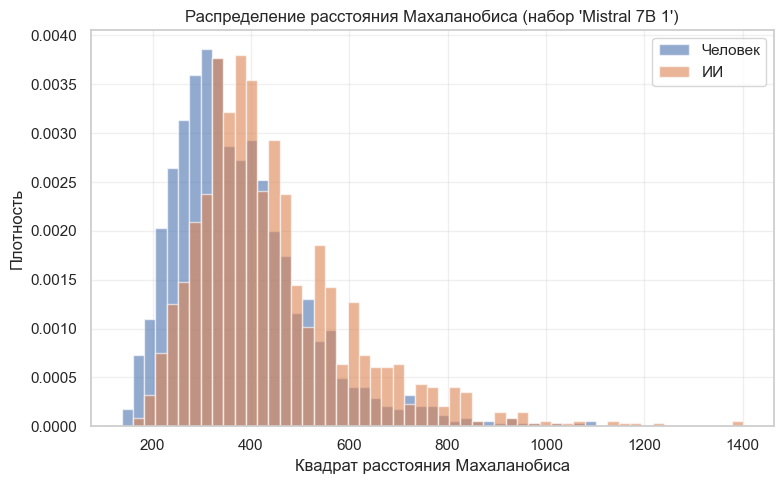

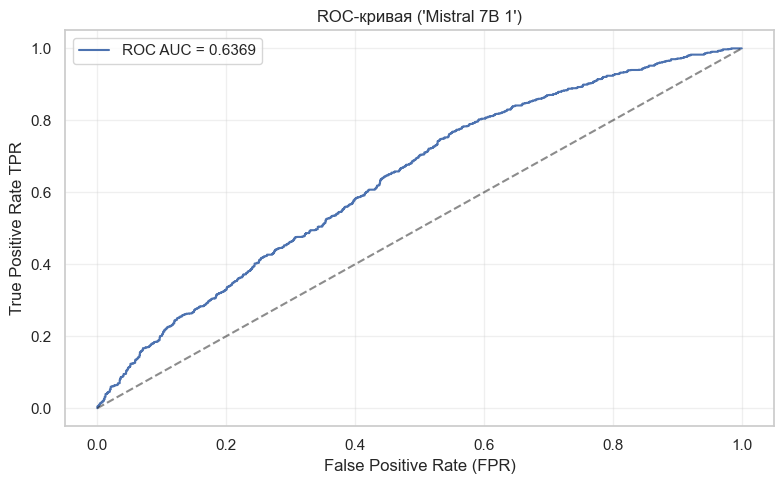

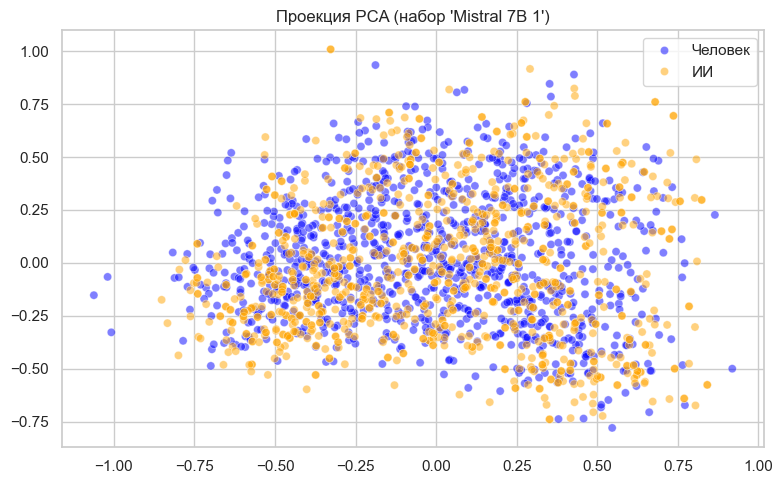


Набор: Mistral 7B 2
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:29<00:00,  3.23it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     376.9366
Стд. отклонение    |                     136.8435
Асимметрия         |                       1.3598
Эксцесс            |                       2.9066
95% квантиль       |                     636.2816
99% квантиль       |                     834.8332

Статистики расстояния Махаланобиса (ии)
Среднее            |                     471.3802
Стд. отклонение    |                     161.3071
Асимметрия         |                       1.9406
Эксцесс            |                       8.8400
95% квантиль       |                     769.1844
99% квантиль       |                    1006.8491

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6956


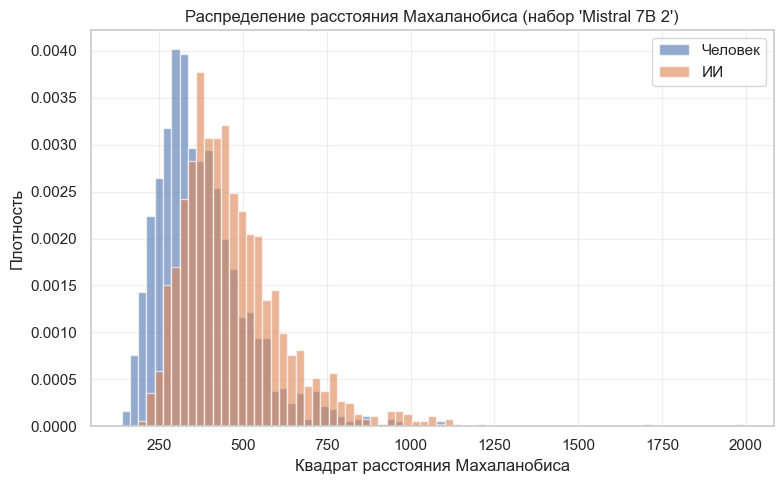

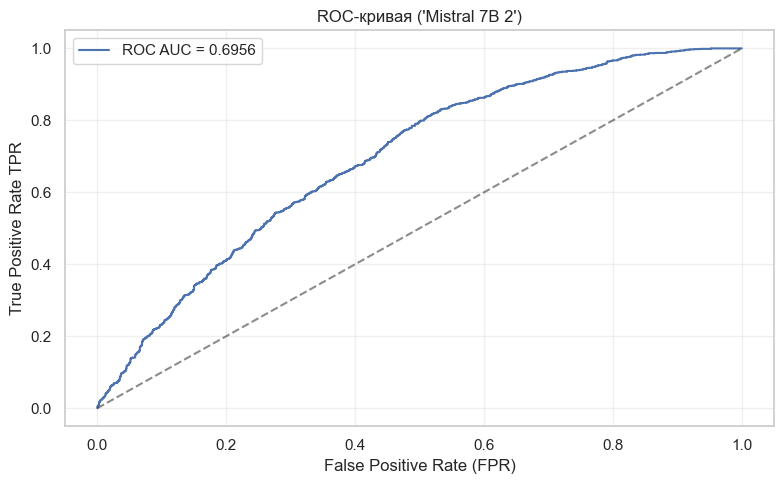

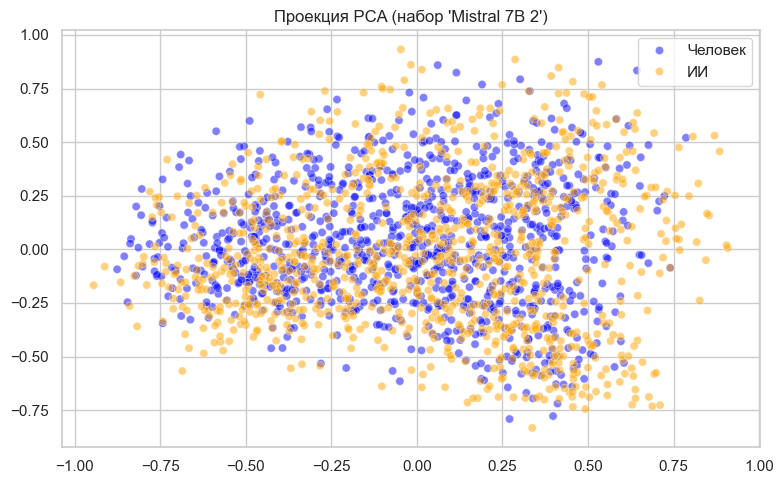


Набор: Mistral 7B 3
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:28<00:00,  3.27it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     376.9366
Стд. отклонение    |                     136.8435
Асимметрия         |                       1.3598
Эксцесс            |                       2.9066
95% квантиль       |                     636.2816
99% квантиль       |                     834.8332

Статистики расстояния Махаланобиса (ии)
Среднее            |                     468.2546
Стд. отклонение    |                     173.9929
Асимметрия         |                       2.0218
Эксцесс            |                       7.9882
95% квантиль       |                     810.6653
99% квантиль       |                    1058.5792

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6788


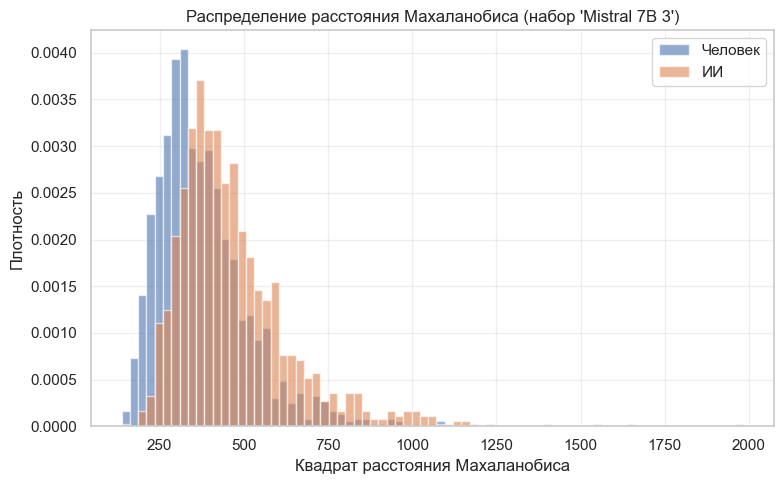

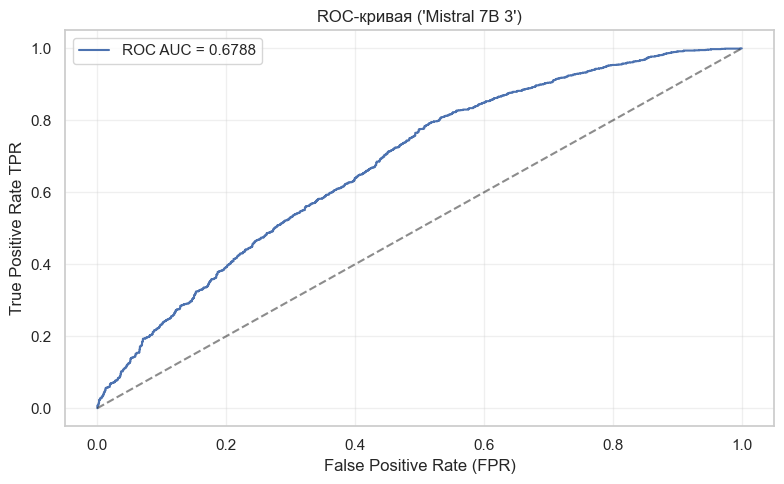

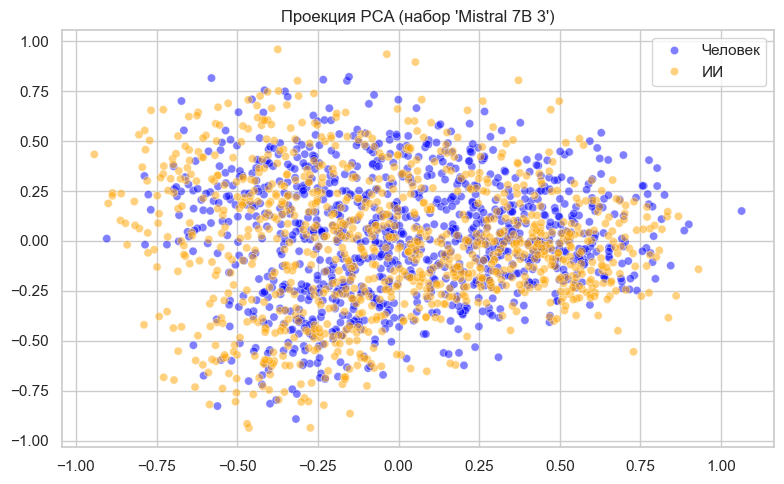


Набор: Mistral 7B 4
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:29<00:00,  3.21it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     376.9366
Стд. отклонение    |                     136.8435
Асимметрия         |                       1.3598
Эксцесс            |                       2.9066
95% квантиль       |                     636.2816
99% квантиль       |                     834.8332

Статистики расстояния Махаланобиса (ии)
Среднее            |                     461.4264
Стд. отклонение    |                     164.5852
Асимметрия         |                       1.9170
Эксцесс            |                       7.1885
95% квантиль       |                     770.1720
99% квантиль       |                    1026.2309

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6733


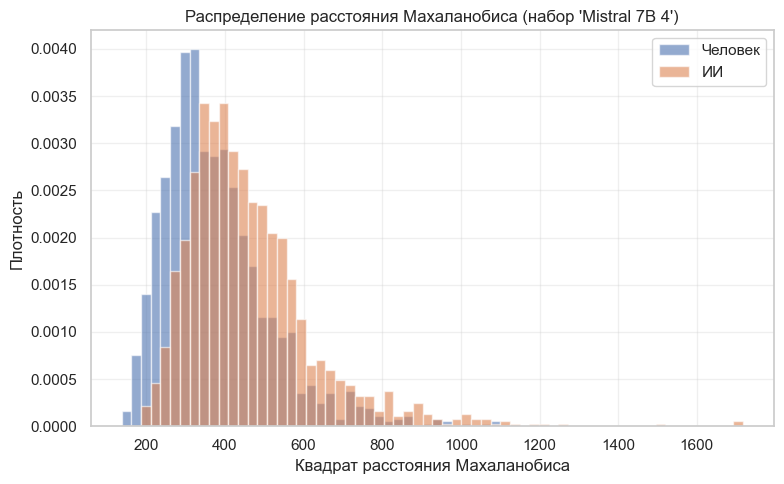

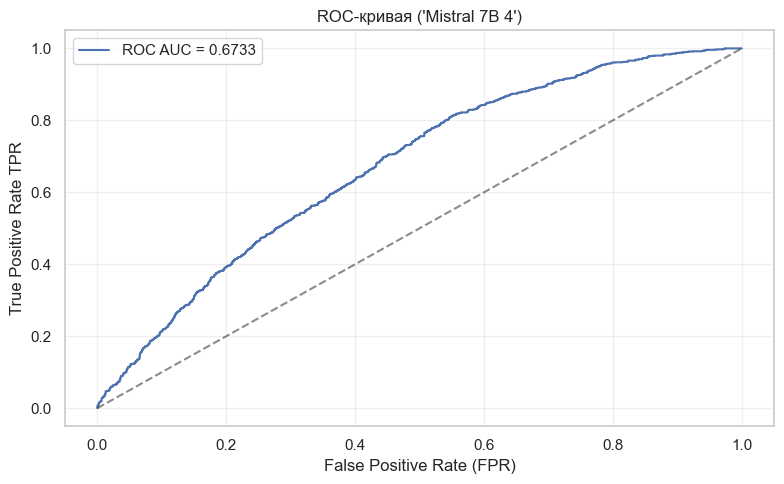

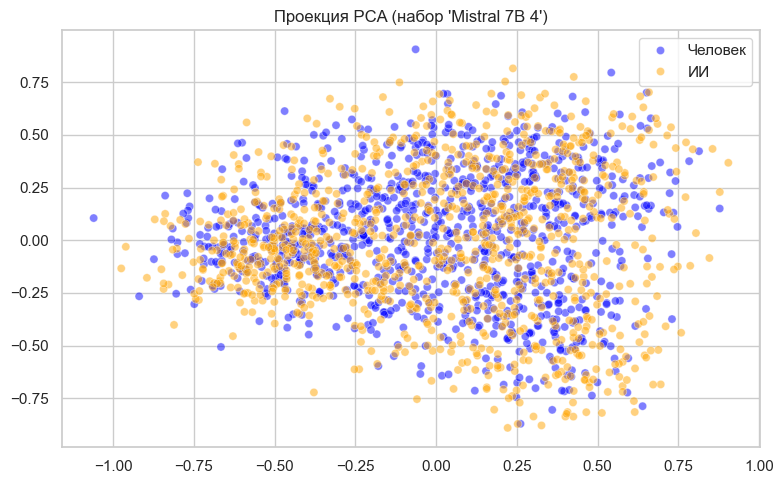


Набор: Mistral 7B 5
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:28<00:00,  3.34it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     376.9366
Стд. отклонение    |                     136.8435
Асимметрия         |                       1.3598
Эксцесс            |                       2.9066
95% квантиль       |                     636.2816
99% квантиль       |                     834.8332

Статистики расстояния Махаланобиса (ии)
Среднее            |                     470.9395
Стд. отклонение    |                     152.6148
Асимметрия         |                       1.8060
Эксцесс            |                       5.7959
95% квантиль       |                     765.5595
99% квантиль       |                     983.7302

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.7046


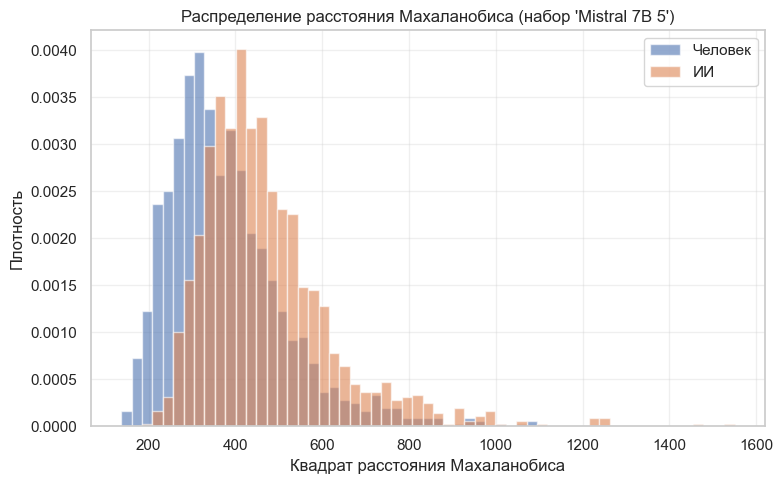

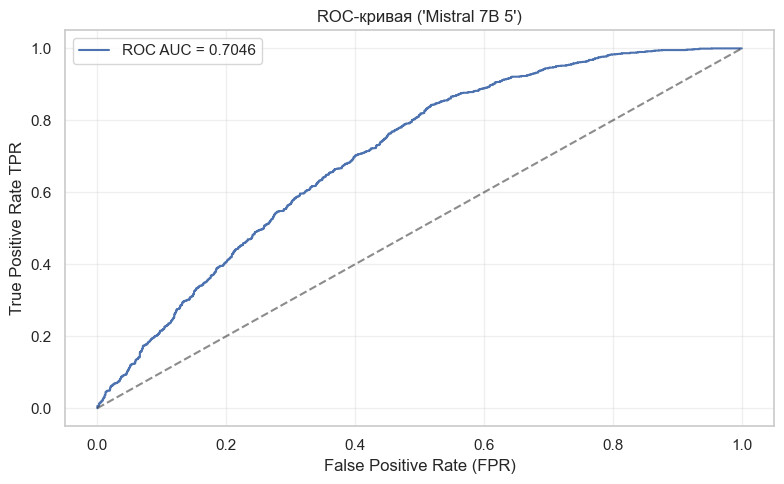

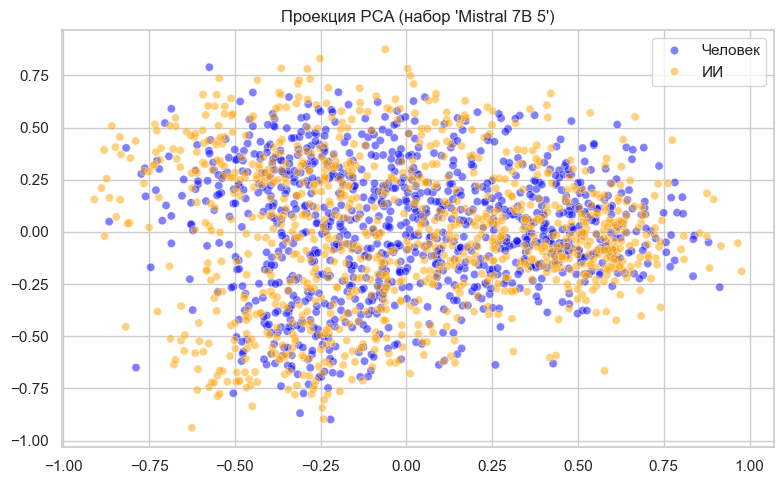


Набор: Llama 3 13B 1
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:19<00:00,  3.27it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     374.5337
Стд. отклонение    |                     133.6256
Асимметрия         |                       1.1937
Эксцесс            |                       2.1391
95% квантиль       |                     625.6919
99% квантиль       |                     777.6679

Статистики расстояния Махаланобиса (ии)
Среднее            |                     439.1300
Стд. отклонение    |                     158.5171
Асимметрия         |                       1.5395
Эксцесс            |                       3.5369
95% квантиль       |                     746.5876
99% квантиль       |                     969.0315

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 999
ROC-AUC                            : 0.6294


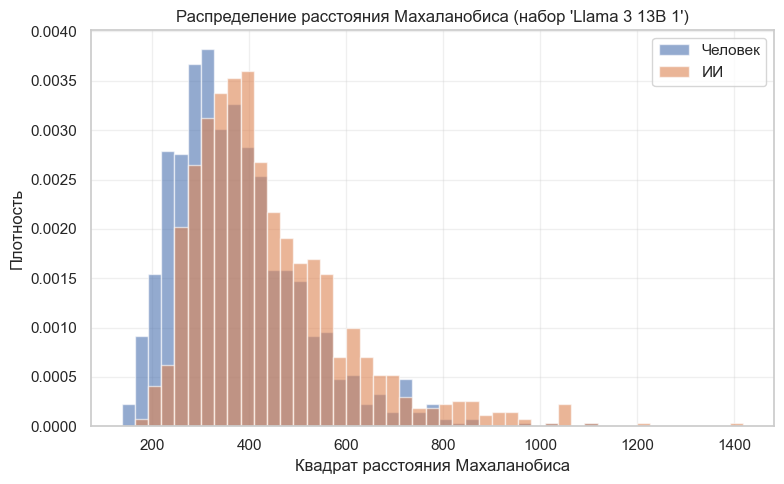

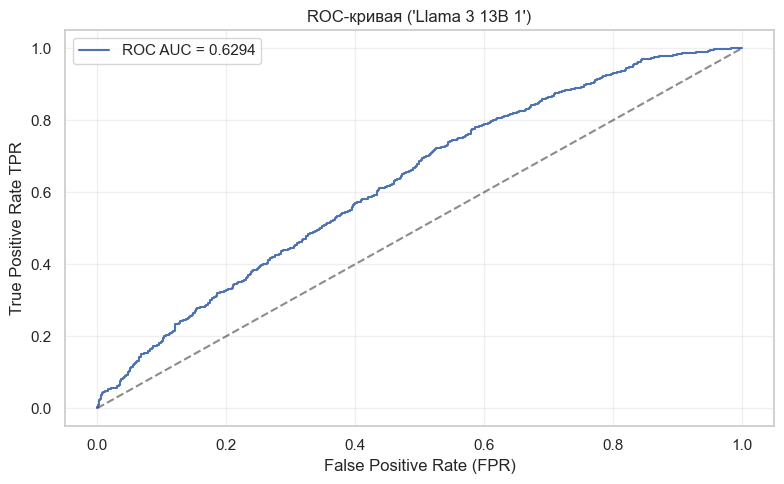

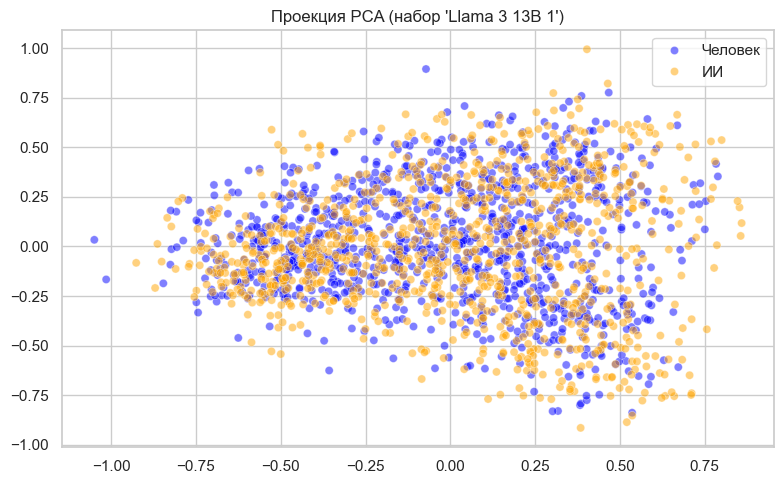


Набор: Llama 3 13B 2
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:19<00:00,  3.17it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     374.4816
Стд. отклонение    |                     133.5689
Асимметрия         |                       1.1951
Эксцесс            |                       2.1445
95% квантиль       |                     625.1070
99% квантиль       |                     777.6277

Статистики расстояния Махаланобиса (ии)
Среднее            |                     447.6080
Стд. отклонение    |                     153.9587
Асимметрия         |                       1.6043
Эксцесс            |                       4.1982
95% квантиль       |                     747.6172
99% квантиль       |                     975.9764

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1000
ROC-AUC                            : 0.6550


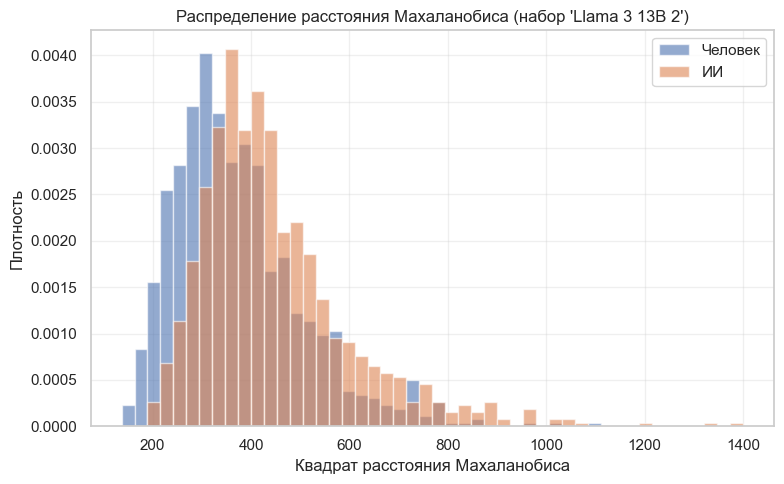

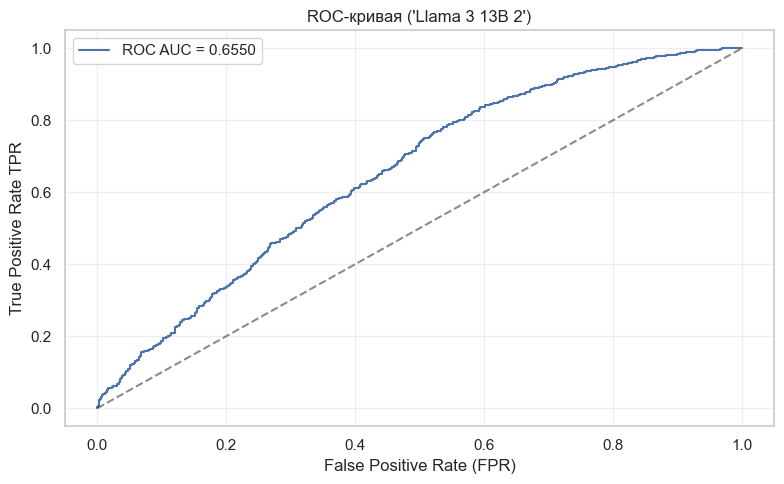

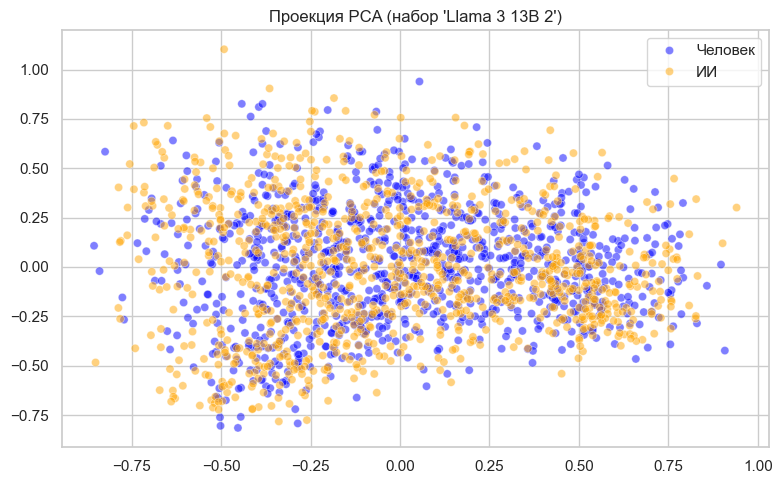


Набор: Llama 3 13B 3
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:19<00:00,  3.22it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     374.9950
Стд. отклонение    |                     133.7052
Асимметрия         |                       1.1916
Эксцесс            |                       2.1306
95% квантиль       |                     628.6167
99% квантиль       |                     777.8691

Статистики расстояния Махаланобиса (ии)
Среднее            |                     465.7421
Стд. отклонение    |                     167.7510
Асимметрия         |                       1.3734
Эксцесс            |                       2.5419
95% квантиль       |                     795.4187
99% квантиль       |                    1042.4966

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 994
ROC-AUC                            : 0.6737


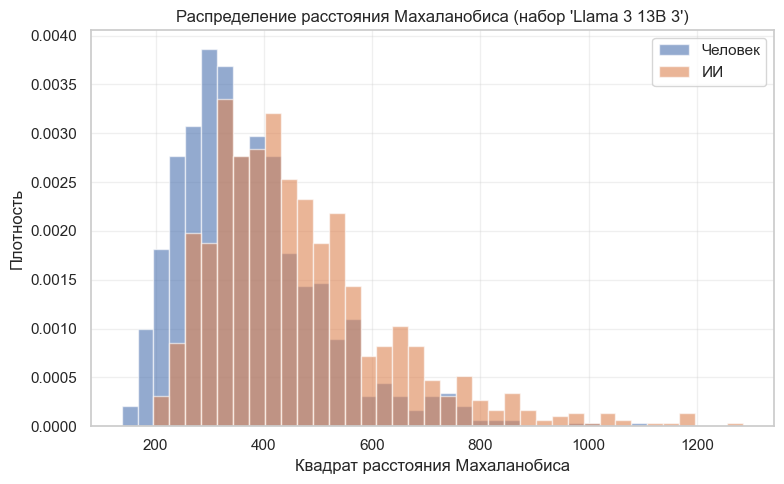

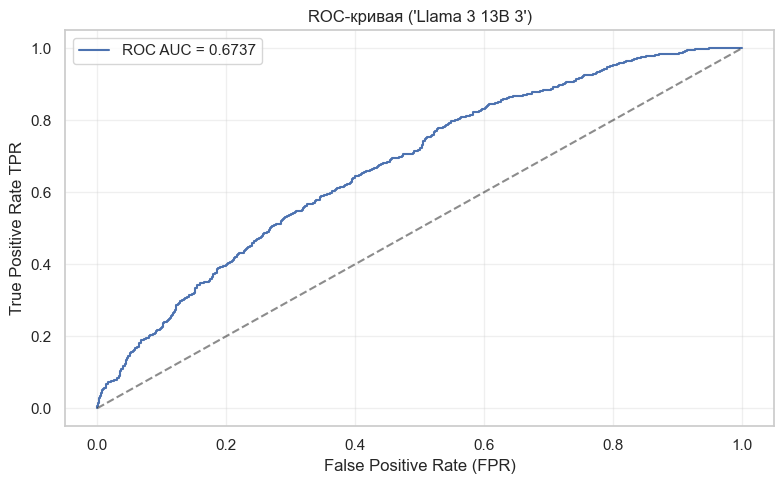

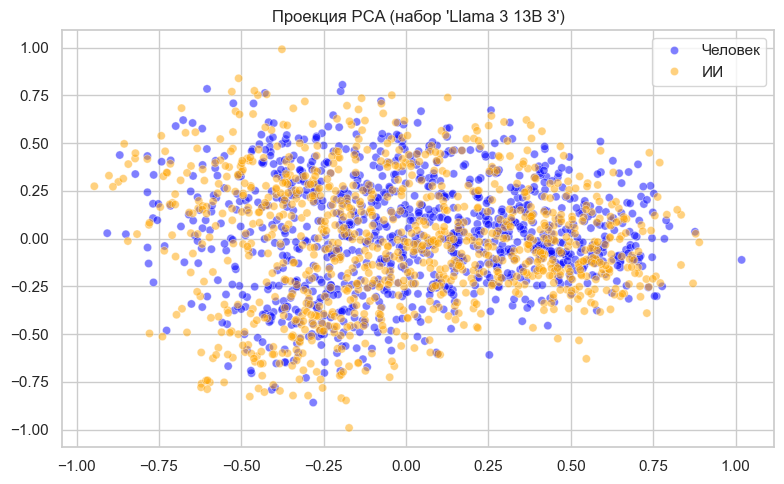


Набор: Llama 3 13B 4
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:19<00:00,  3.29it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     374.6975
Стд. отклонение    |                     133.6336
Асимметрия         |                       1.1947
Эксцесс            |                       2.1388
95% квантиль       |                     626.8618
99% квантиль       |                     777.7484

Статистики расстояния Махаланобиса (ии)
Среднее            |                     447.5430
Стд. отклонение    |                     164.9755
Асимметрия         |                       1.9248
Эксцесс            |                       6.5775
95% квантиль       |                     732.5726
99% квантиль       |                    1065.0295

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 997
ROC-AUC                            : 0.6458


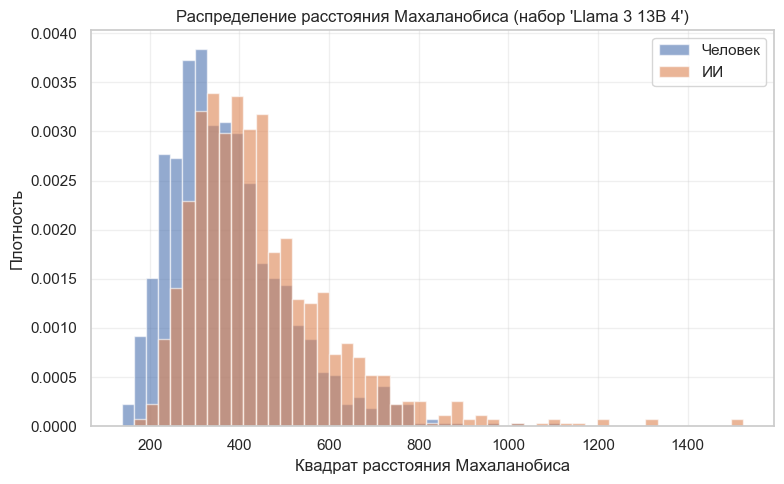

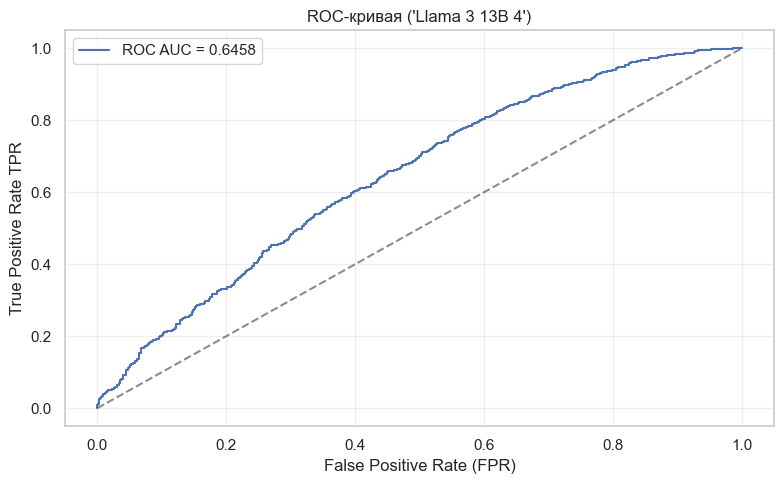

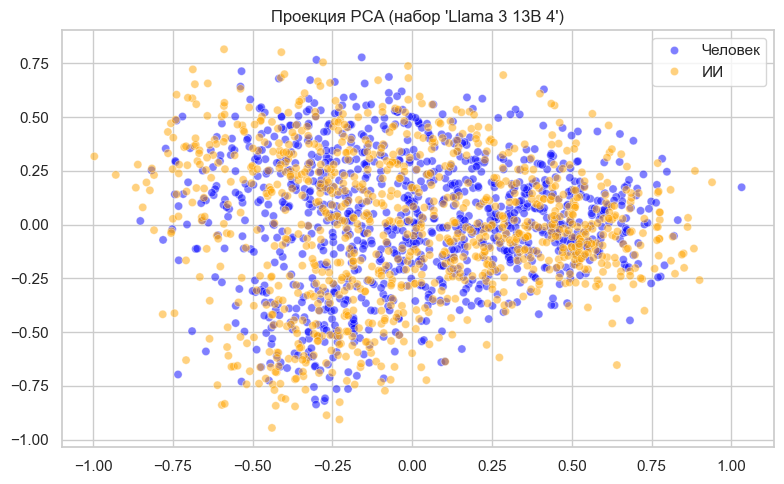


Набор: Llama 3 13B 5
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:19<00:00,  3.30it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     374.5337
Стд. отклонение    |                     133.6256
Асимметрия         |                       1.1937
Эксцесс            |                       2.1391
95% квантиль       |                     625.6919
99% квантиль       |                     777.6679

Статистики расстояния Махаланобиса (ии)
Среднее            |                     445.9586
Стд. отклонение    |                     202.6802
Асимметрия         |                      10.1761
Эксцесс            |                     202.2505
95% квантиль       |                     727.4408
99% квантиль       |                    1023.8285

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 999
ROC-AUC                            : 0.6460


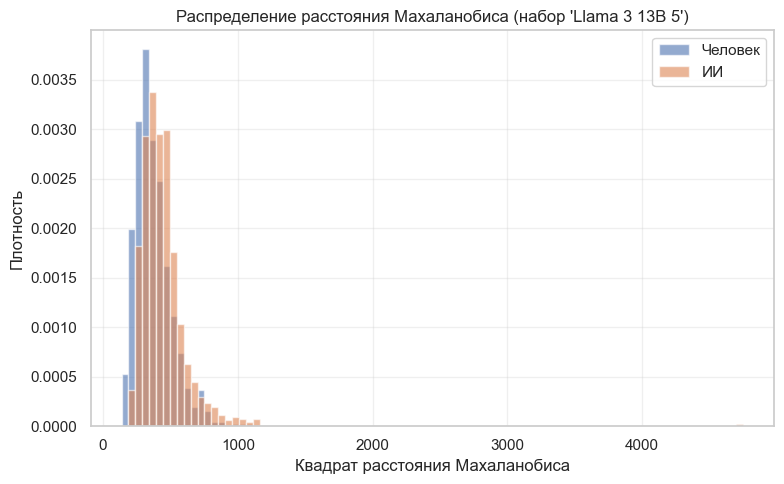

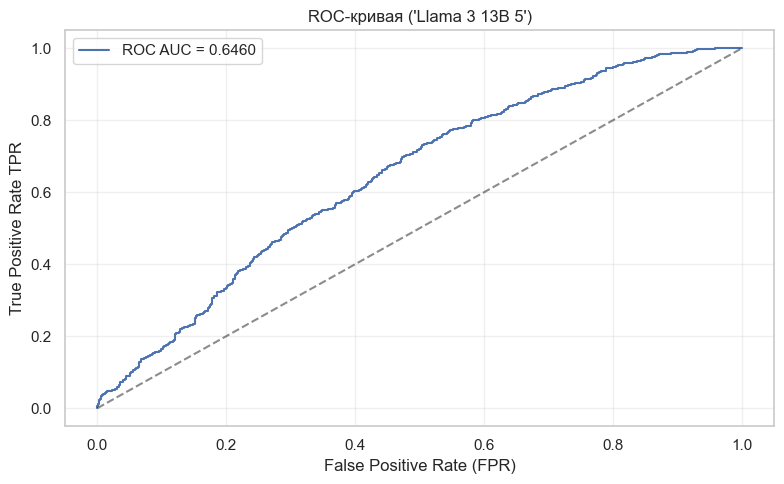

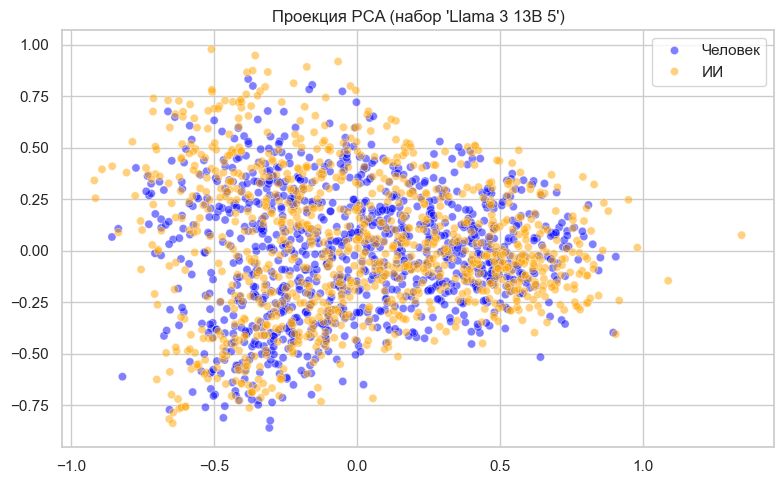


Набор: DeepSeek V3.2 1
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [00:59<00:00,  3.17it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.1532
Стд. отклонение    |                     138.1410
Асимметрия         |                       1.5146
Эксцесс            |                       3.7607
95% квантиль       |                     641.0309
99% квантиль       |                     831.2383

Статистики расстояния Махаланобиса (ии)
Среднее            |                     386.2931
Стд. отклонение    |                     148.8751
Асимметрия         |                       2.0029
Эксцесс            |                       6.9268
95% квантиль       |                     684.3647
99% квантиль       |                     880.7043

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.5227


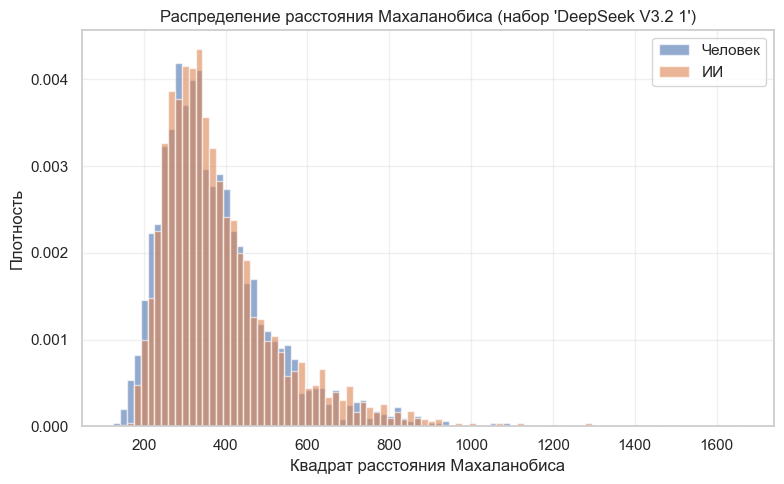

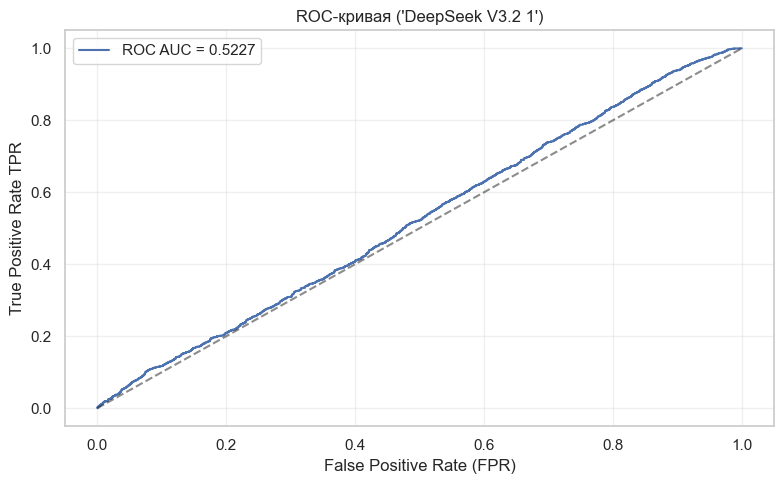

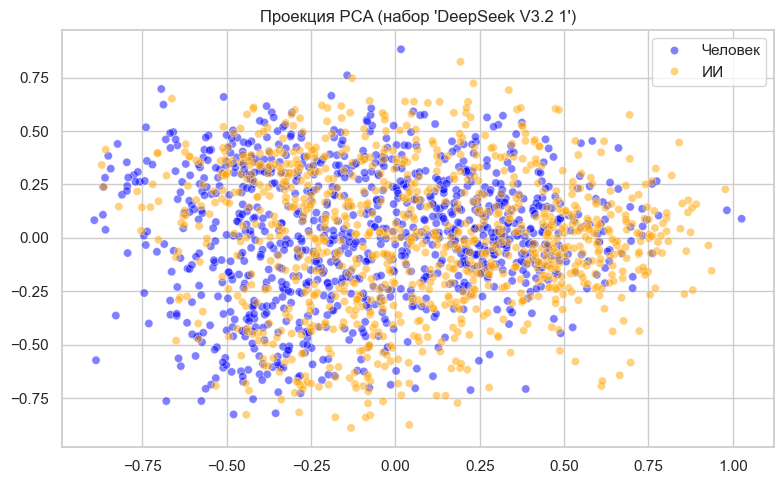


Набор: DeepSeek V3.2 2
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [01:00<00:00,  3.11it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.1532
Стд. отклонение    |                     138.1410
Асимметрия         |                       1.5146
Эксцесс            |                       3.7607
95% квантиль       |                     641.0309
99% квантиль       |                     831.2383

Статистики расстояния Махаланобиса (ии)
Среднее            |                     405.2248
Стд. отклонение    |                     140.9034
Асимметрия         |                       1.6652
Эксцесс            |                       3.8529
95% квантиль       |                     694.4556
99% квантиль       |                     881.9353

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.5786


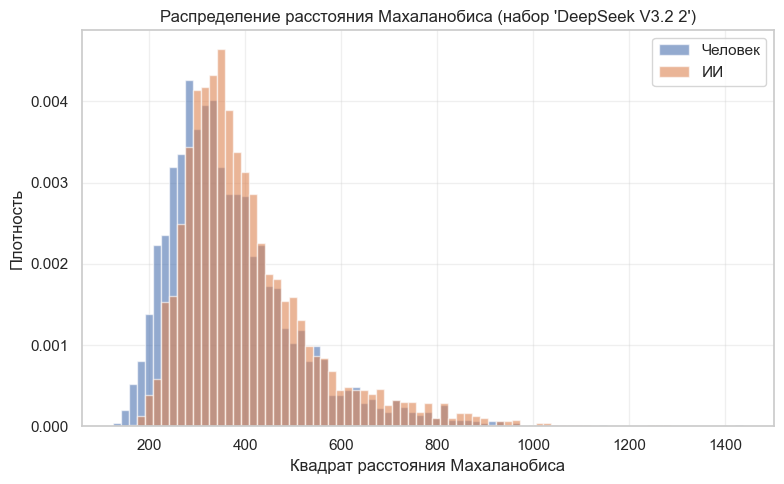

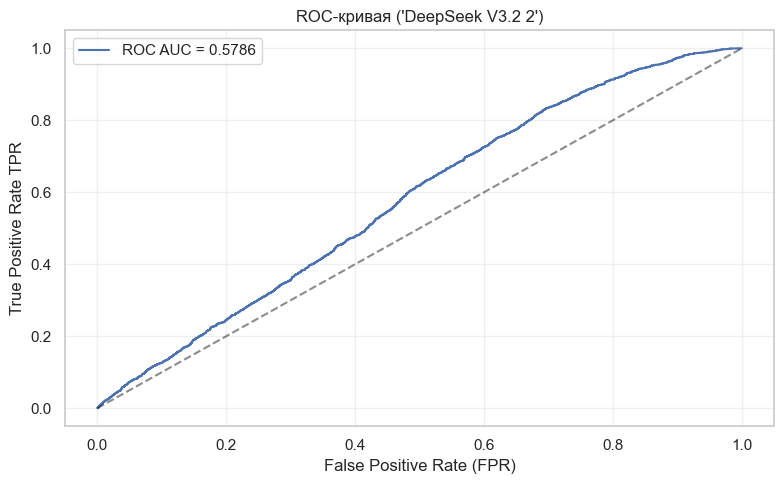

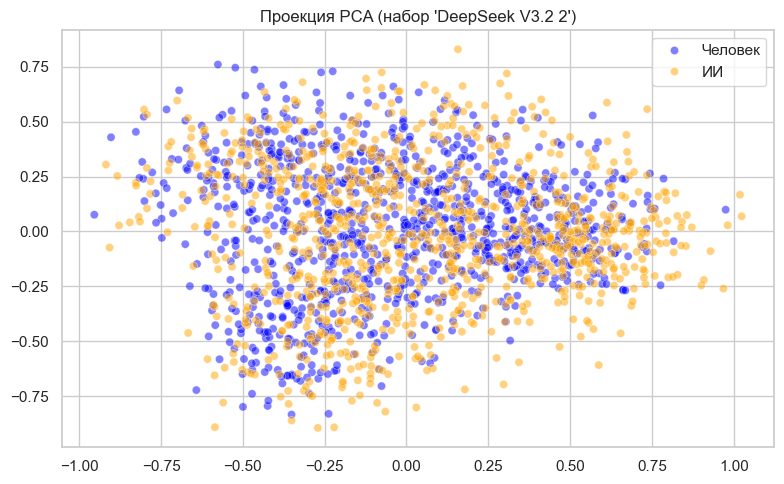


Набор: DeepSeek V3.2 3
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [00:58<00:00,  3.22it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.0644
Стд. отклонение    |                     138.0785
Асимметрия         |                       1.5167
Эксцесс            |                       3.7745
95% квантиль       |                     641.0796
99% квантиль       |                     831.2739

Статистики расстояния Махаланобиса (ии)
Среднее            |                     394.6061
Стд. отклонение    |                     150.5972
Асимметрия         |                       1.7616
Эксцесс            |                       4.8838
95% квантиль       |                     706.4495
99% квантиль       |                     887.0441

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2999
ROC-AUC                            : 0.5411


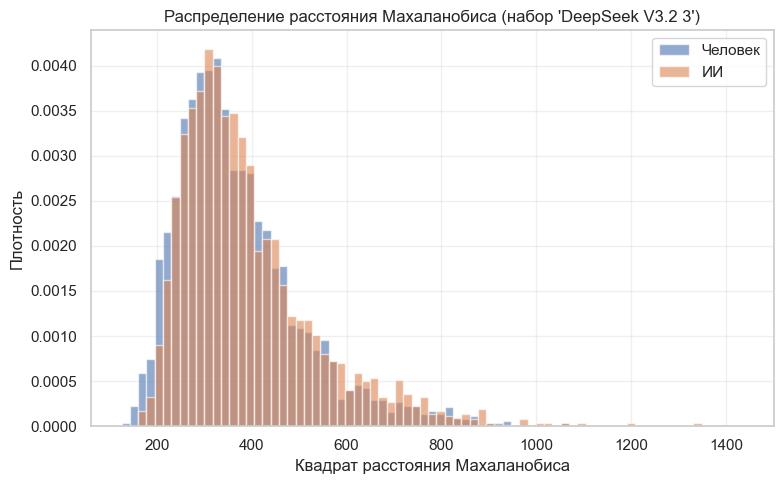

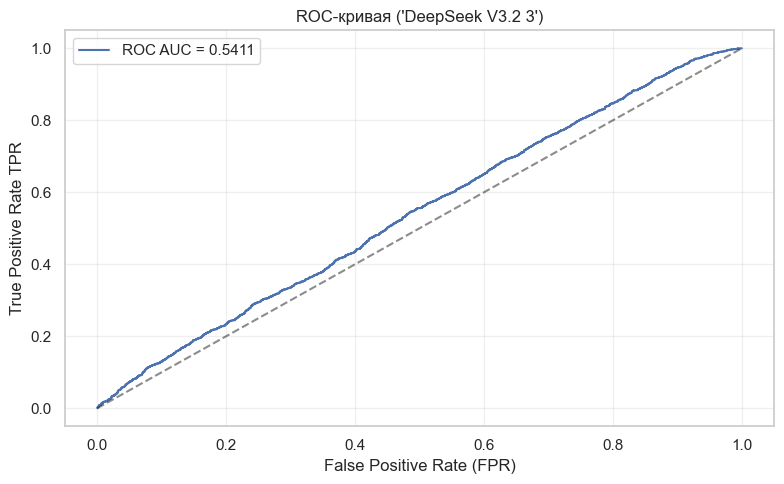

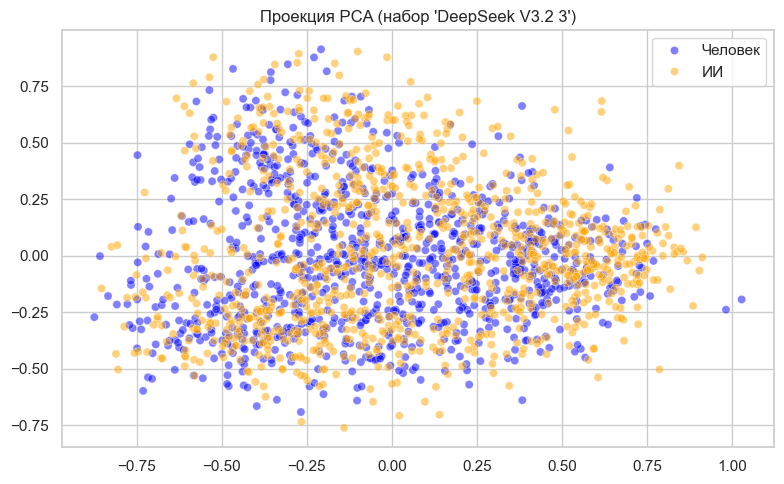


Набор: DeepSeek V3.2 4
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [00:58<00:00,  3.19it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.1532
Стд. отклонение    |                     138.1410
Асимметрия         |                       1.5146
Эксцесс            |                       3.7607
95% квантиль       |                     641.0309
99% квантиль       |                     831.2383

Статистики расстояния Махаланобиса (ии)
Среднее            |                     393.9864
Стд. отклонение    |                     138.7987
Асимметрия         |                       1.5399
Эксцесс            |                       3.0432
95% квантиль       |                     670.8624
99% квантиль       |                     871.0829

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.5500


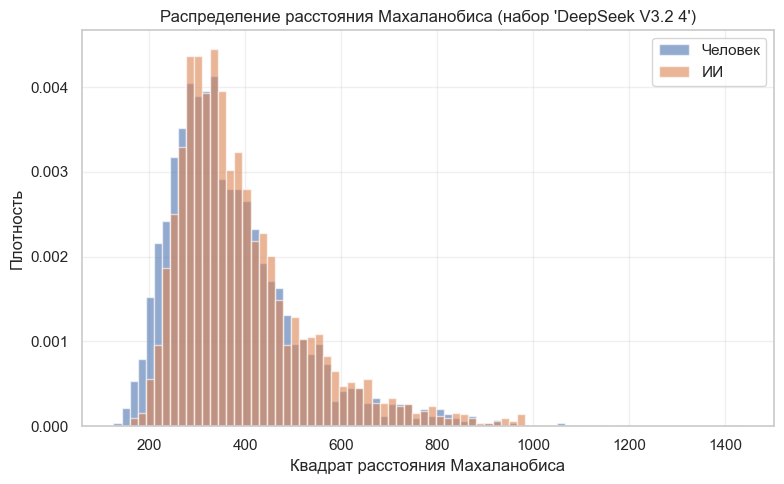

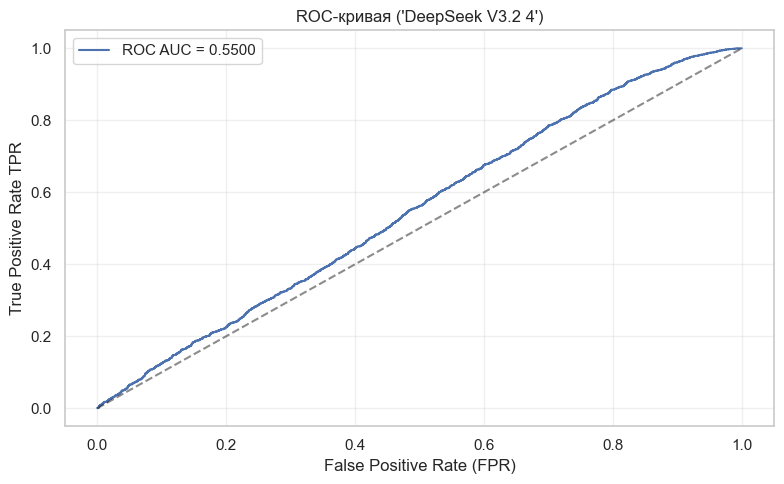

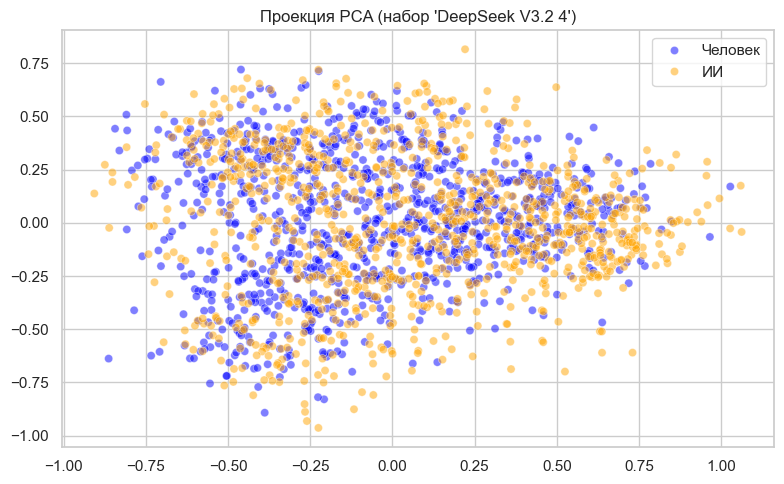


Набор: DeepSeek V3.2 5
----------------------------------------


100%|█████████████████████████████████████████| 157/157 [00:44<00:00,  3.52it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.5431
Стд. отклонение    |                     137.6409
Асимметрия         |                       1.4352
Эксцесс            |                       2.9869
95% квантиль       |                     640.9505
99% квантиль       |                     837.0881

Статистики расстояния Махаланобиса (ии)
Среднее            |                     409.7667
Стд. отклонение    |                     127.0804
Асимметрия         |                       1.6310
Эксцесс            |                       3.8477
95% квантиль       |                     669.5415
99% квантиль       |                     849.6159

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2500
ROC-AUC                            : 0.6044


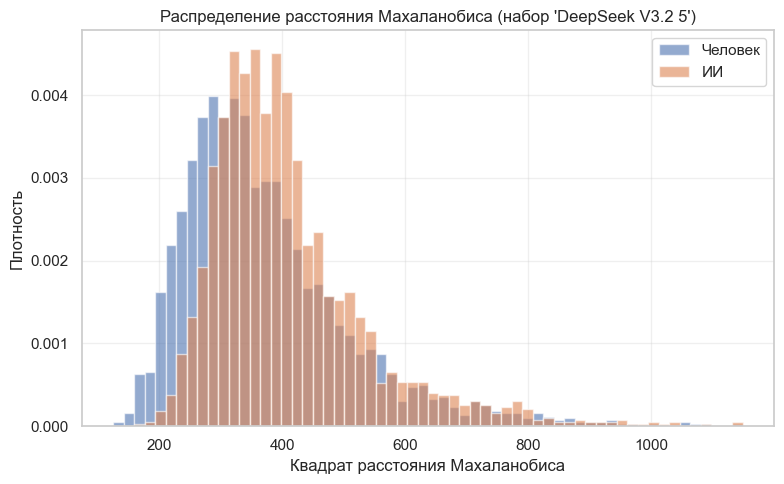

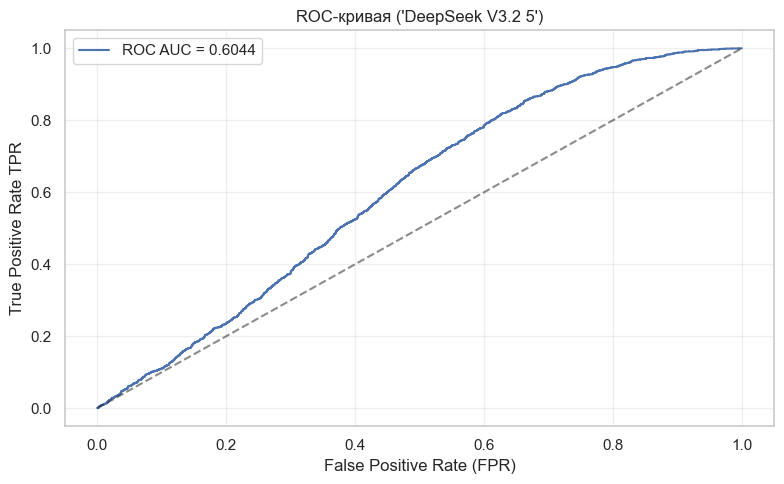

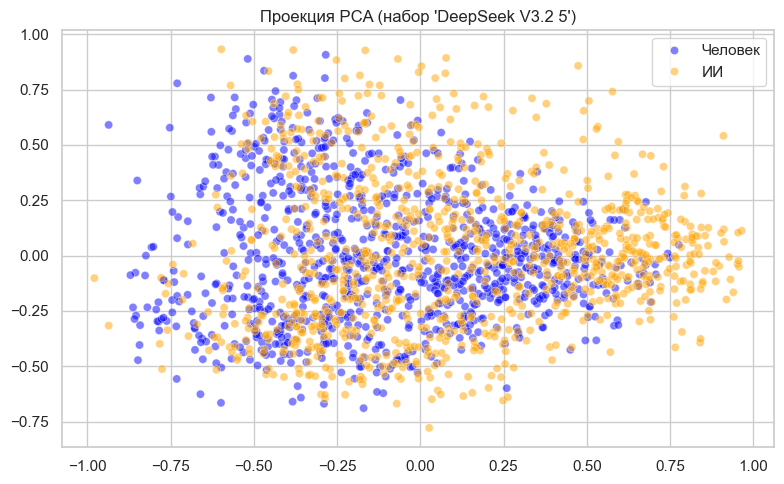


Набор: ChatGPT 1
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:39<00:00,  3.19it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.9277
Стд. отклонение    |                     135.6958
Асимметрия         |                       1.3695
Эксцесс            |                       2.7697
95% квантиль       |                     636.2816
99% квантиль       |                     834.7897

Статистики расстояния Махаланобиса (ии)
Среднее            |                     437.8651
Стд. отклонение    |                     161.9589
Асимметрия         |                       1.6089
Эксцесс            |                       3.9859
95% квантиль       |                     758.0516
99% квантиль       |                     965.3861

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.6292


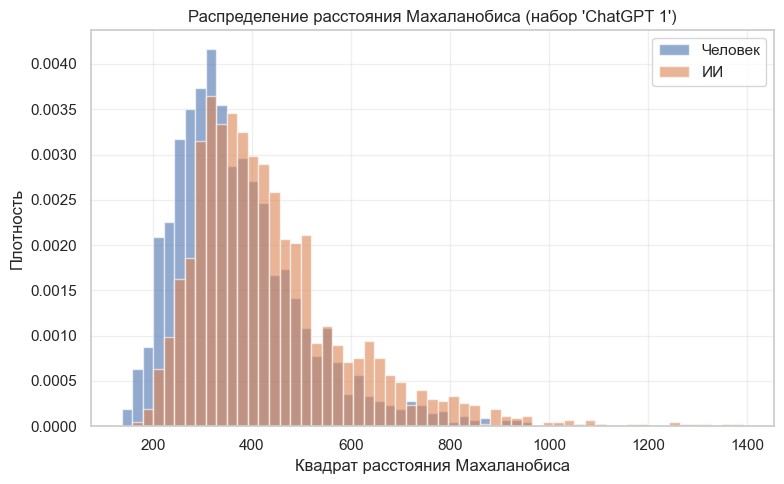

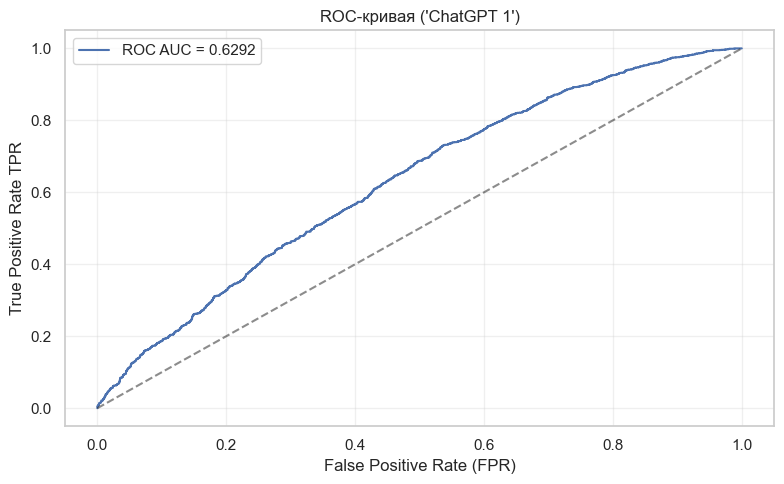

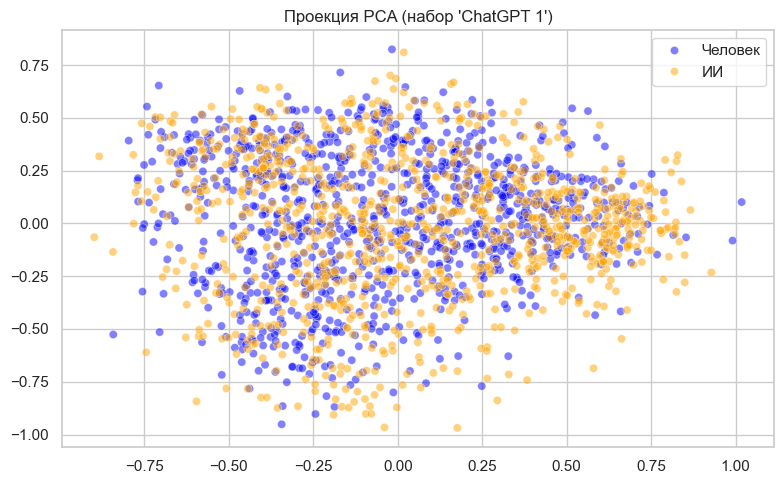


Набор: ChatGPT 2
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:39<00:00,  3.16it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.9277
Стд. отклонение    |                     135.6958
Асимметрия         |                       1.3695
Эксцесс            |                       2.7697
95% квантиль       |                     636.2816
99% квантиль       |                     834.7897

Статистики расстояния Махаланобиса (ии)
Среднее            |                     480.9323
Стд. отклонение    |                     158.5729
Асимметрия         |                       1.3378
Эксцесс            |                       2.5667
95% квантиль       |                     789.7996
99% квантиль       |                     987.5937

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.7194


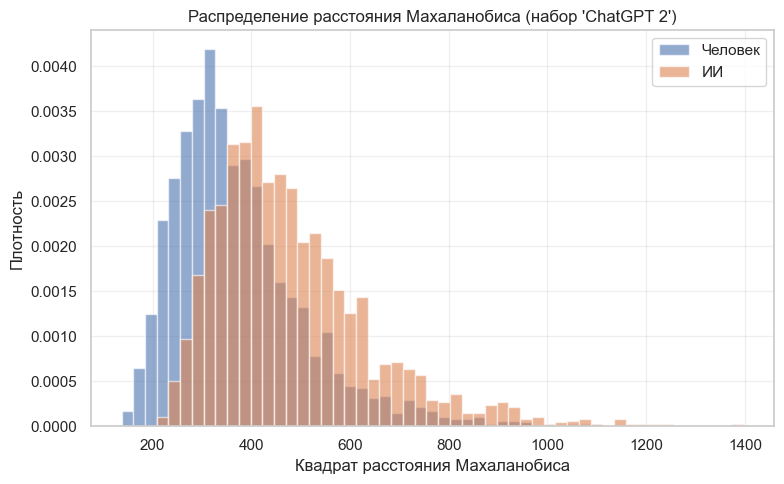

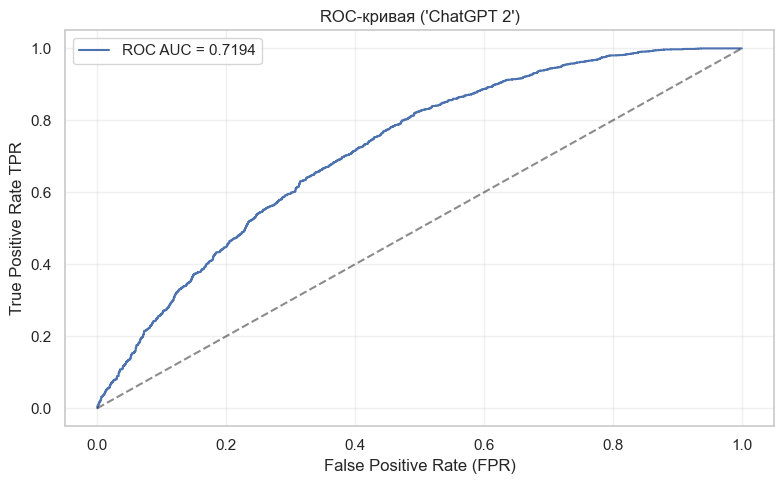

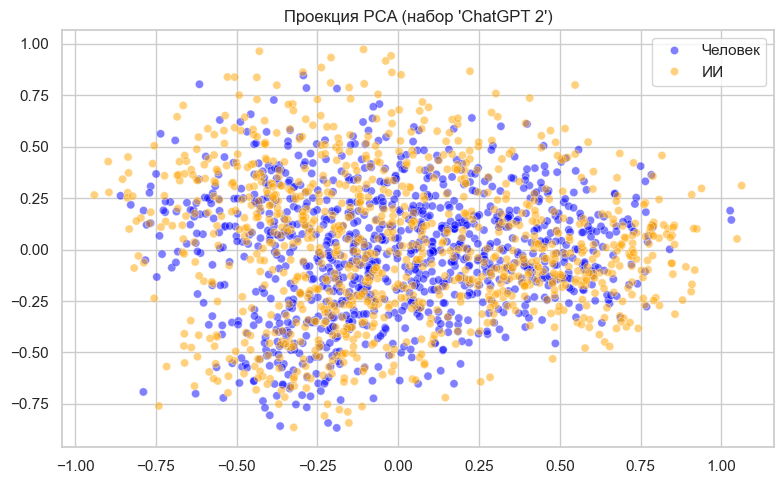


Набор: ChatGPT 3
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:28<00:00,  4.41it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.9277
Стд. отклонение    |                     135.6958
Асимметрия         |                       1.3695
Эксцесс            |                       2.7697
95% квантиль       |                     636.2816
99% квантиль       |                     834.7897

Статистики расстояния Махаланобиса (ии)
Среднее            |                     444.0380
Стд. отклонение    |                     163.2108
Асимметрия         |                       1.4464
Эксцесс            |                       3.1798
95% квантиль       |                     759.3076
99% квантиль       |                     980.0660

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.6394


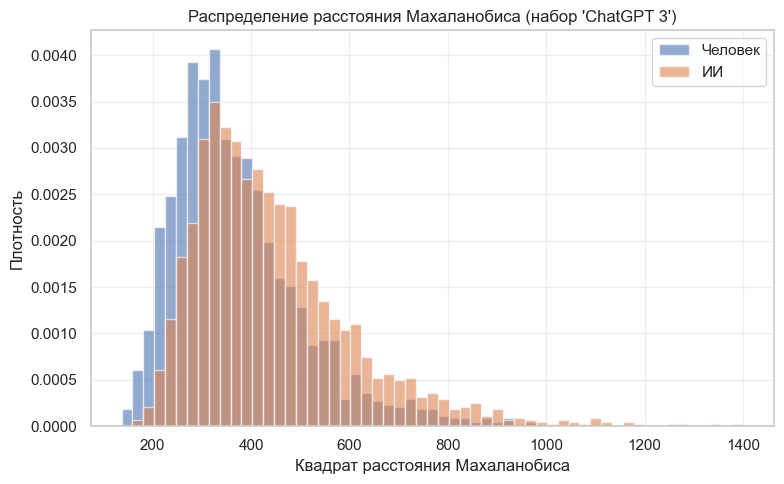

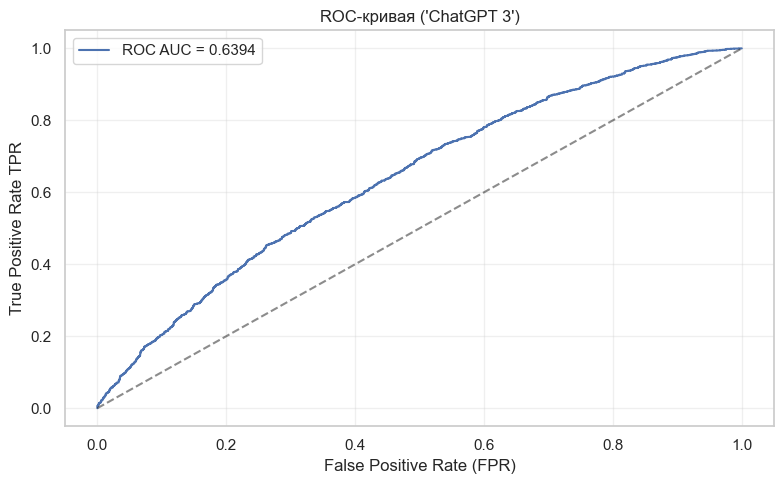

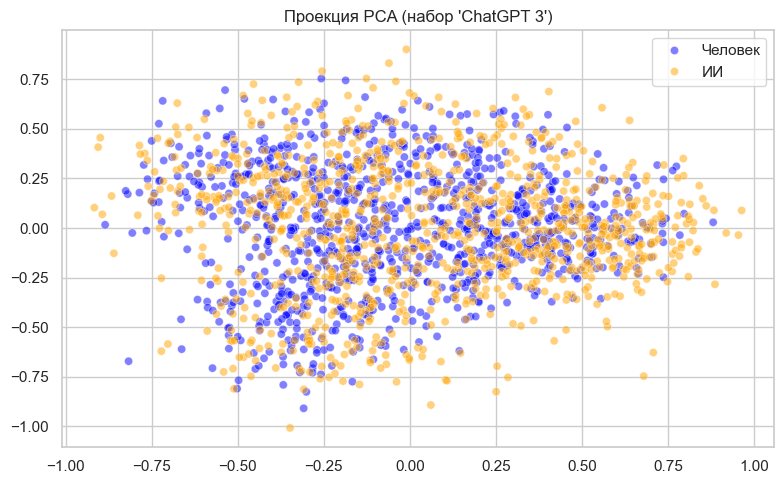


Набор: ChatGPT 4
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:21<00:00,  5.91it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.9277
Стд. отклонение    |                     135.6958
Асимметрия         |                       1.3695
Эксцесс            |                       2.7697
95% квантиль       |                     636.2816
99% квантиль       |                     834.7897

Статистики расстояния Махаланобиса (ии)
Среднее            |                     456.4856
Стд. отклонение    |                     166.0574
Асимметрия         |                       1.9778
Эксцесс            |                       7.2078
95% квантиль       |                     762.1529
99% квантиль       |                     987.3728

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.6699


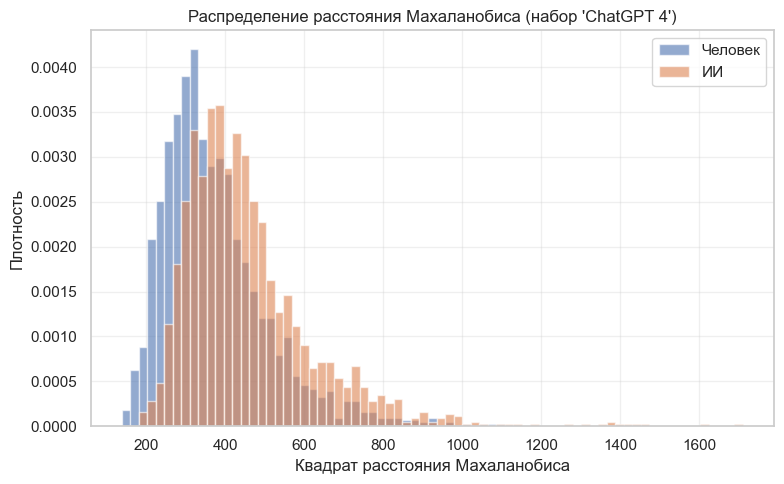

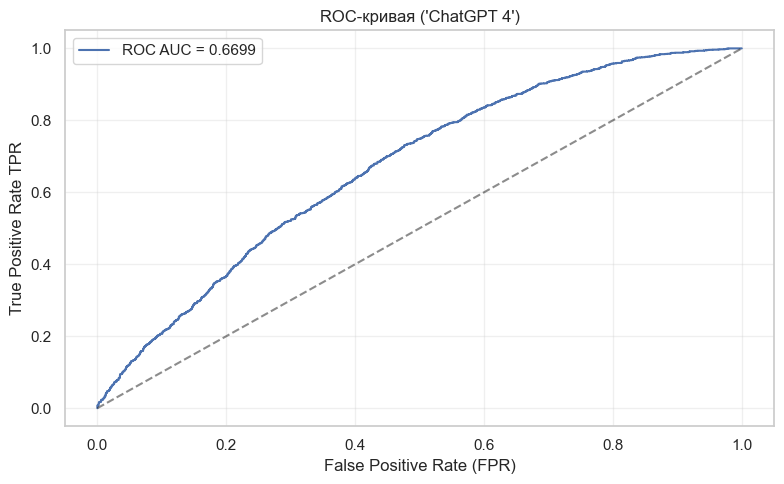

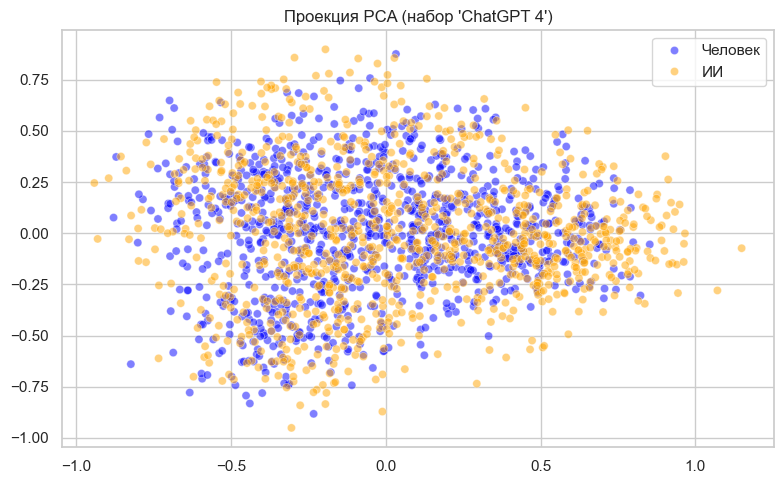


Набор: ChatGPT 5
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:22<00:00,  5.55it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     373.9277
Стд. отклонение    |                     135.6958
Асимметрия         |                       1.3695
Эксцесс            |                       2.7697
95% квантиль       |                     636.2816
99% квантиль       |                     834.7897

Статистики расстояния Махаланобиса (ии)
Среднее            |                     486.5818
Стд. отклонение    |                     156.2382
Асимметрия         |                       1.4274
Эксцесс            |                       3.1263
95% квантиль       |                     789.9271
99% квантиль       |                    1012.0334

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.7343


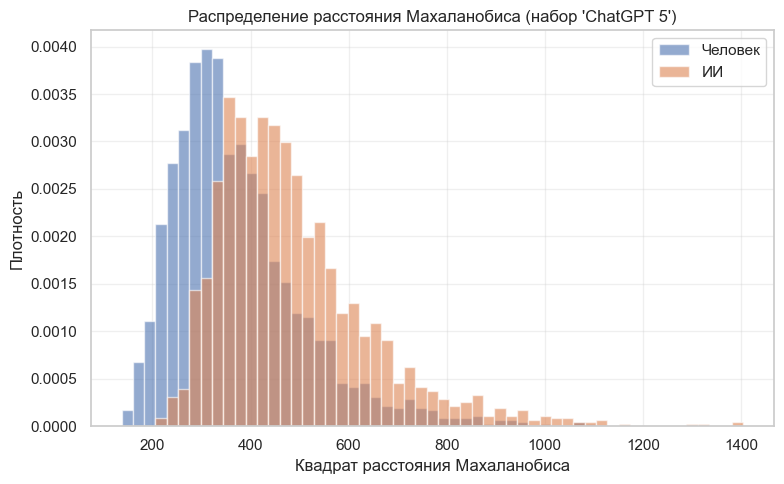

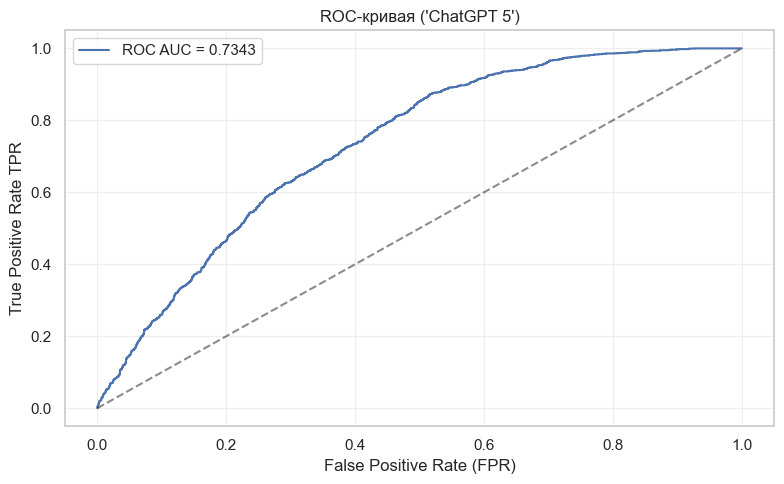

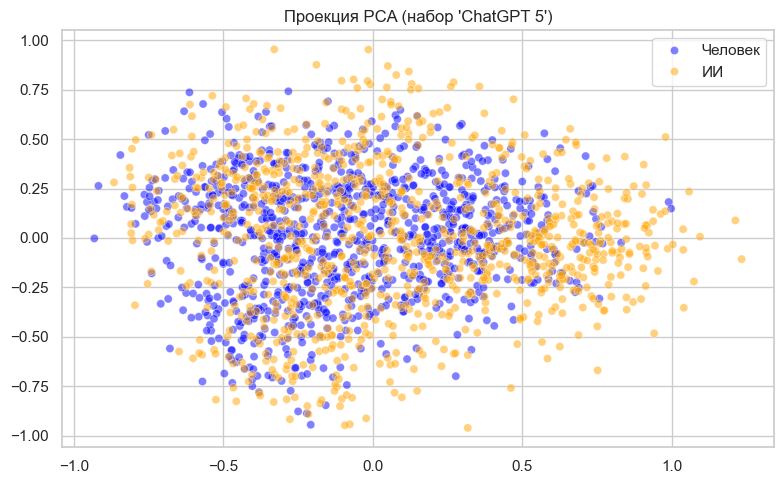

In [7]:
results = []

print_header(f"ENCODER: {ENCODER}")

tokenizer = AutoTokenizer.from_pretrained(ENCODER)
model = AutoModel.from_pretrained(ENCODER)

X_human = get_embeddings(tokenizer, model, human_df["text"])
X_human = X_human.numpy().astype(np.float32)

print_norm_stats(X_human)

X_h_train, X_h_test = train_test_split(
    X_human,
    test_size=0.3,
    random_state=SEED
)

print_kv("Эмбеддинги живых текстов (train)", len(X_h_train))
print_kv("Эмбеддинги живых текстов (test)", len(X_h_test))

cov = LedoitWolf().fit(X_h_train)
scores_h_train = cov.mahalanobis(X_h_train)

covariance_spectrum(cov)

for name, ai_df in ai_datasets.items():
    print(f"\nНабор: {name}")
    print("-" * 40)

    X_ai = get_embeddings(tokenizer, model, ai_df["text"])
    X_ai = X_ai.numpy().astype(np.float32)

    n = min(len(X_h_test), len(X_ai))

    X_test = np.vstack([X_h_test[:n], X_ai[:n]])
    y_test = np.concatenate([
        np.zeros(n, dtype=int),
        np.ones(n, dtype=int)
    ])

    scores = cov.mahalanobis(X_test)
    scores_human = scores[:n]
    scores_ai = scores[n:]

    print_mahalanobis_stats(scores_human, "человек")
    print_mahalanobis_stats(scores_ai, "ии")

    roc_auc = roc_auc_score(y_test, scores)

    print_kv("Количество объектов в 0 классе", len(X_h_test))
    print_kv("Количество объектов в 1 классе", len(X_ai))
    print_kv("ROC-AUC", f"{roc_auc:.4f}")

    plot_mahalanobis_distributions(scores_human, scores_ai, name)
    plot_roc_curve(y_test, scores, roc_auc, name)
    plot_pca_projection(X_h_test, X_ai, name)

    results.append({
        "dataset": name,
        "size": len(X_test),
        "roc_auc": roc_auc,
    })

In [8]:
results_df = pd.DataFrame(results)
print(results_df)

            dataset  size   roc_auc
0      Mistral 7B 1  3000  0.636911
1      Mistral 7B 2  3000  0.695597
2      Mistral 7B 3  3000  0.678785
3      Mistral 7B 4  3000  0.673259
4      Mistral 7B 5  3000  0.704638
5     Llama 3 13B 1  1998  0.629441
6     Llama 3 13B 2  2000  0.655023
7     Llama 3 13B 3  1988  0.673693
8     Llama 3 13B 4  1994  0.645779
9     Llama 3 13B 5  1998  0.645954
10  DeepSeek V3.2 1  6000  0.522734
11  DeepSeek V3.2 2  6000  0.578618
12  DeepSeek V3.2 3  5998  0.541050
13  DeepSeek V3.2 4  6000  0.549953
14  DeepSeek V3.2 5  5000  0.604369
15        ChatGPT 1  4000  0.629200
16        ChatGPT 2  4000  0.719419
17        ChatGPT 3  4000  0.639423
18        ChatGPT 4  4000  0.669904
19        ChatGPT 5  4000  0.734290
